# __Finding ROI with Orientation__

Finding the ROI of the volumes by checking the global extreme pixels for each class.

In [1]:
import os
import numpy as np
import json
import nibabel as nib
from nibabel.processing import resample_from_to 
import src.data.transforms as transforms
from nibabel.orientations import apply_orientation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
os.chdir('C:\\Users\\Usuario\\TFG\\digipanca\\')
data_dir = 'data/raw/'
split_path = 'data/splits/train_val_split.json'
with open(split_path, "r") as f:
    split_data = json.load(f)
# Train data
train_patients = split_data["train"]
# Orientation
reorient = transforms.Orientation(('R', 'P', 'S'))

In [3]:
extreme_values = {
    "pancreas": None,
    "tumor": None,
    "arteries": None,
    "veins": None
}

__Iterate over the patients__

In [4]:
for patient_id in train_patients:
    image_path = os.path.join(data_dir, patient_id, "SEQ", f"CTport-{patient_id}.nii")
    mask_paths = {
        "pancreas": os.path.join(data_dir, patient_id, "SEG", f"Pancreas-{patient_id}.nii"),
        "tumor": os.path.join(data_dir, patient_id, "SEG", f"Tumor-{patient_id}.nii"),
        "arteries": os.path.join(data_dir, patient_id, "SEG", f"Arterias-{patient_id}.nii"),
        "veins": os.path.join(data_dir, patient_id, "SEG", f"Venas-{patient_id}.nii"),
    }

    image_nii = nib.load(image_path)

    _, transform = reorient(image_nii) # Reorient the image

    for structure, mask_path in mask_paths.items():
        if not os.path.exists(mask_path):
            print(f"⚠️ Warning: Mask {structure} not found for patient {patient_id}")
            continue

        mask_nii = nib.load(mask_path)
        if mask_nii.shape[2] != image_nii.shape[2]:
            print(f"\tresampling patient {patient_id}")
            mask_nii = resample_from_to(mask_nii, image_nii, order=0)
        mask = mask_nii.get_fdata().astype(np.int32)

        # Apply orientation transformation
        mask = apply_orientation(mask, transform)

        # Rotate the mask
        mask = np.rot90(mask, k=-1, axes=(0, 1))

        # Get coords
        coords = np.argwhere(mask > 0)  # Pixels with mask value

        if coords.size == 0:
            print(f"⚠️ Warning: Mask ({structure}) is empty for patient {patient_id}")
            continue  # Skip empty masks

        min_h, min_w, min_d = coords.min(axis=0)  # Min H, W, D
        max_h, max_w, max_d = coords.max(axis=0)  # Min H, W, D

        # Initialize for first time
        if extreme_values[structure] is None:
            extreme_values[structure] = {
                "min_h": min_h, "max_h": max_h,
                "min_w": min_w, "max_w": max_w,
                "min_d": min_d, "max_d": max_d
            }
        else:
            # Update min and max
            extreme_values[structure]["min_h"] = min(extreme_values[structure]["min_h"], min_h)
            extreme_values[structure]["max_h"] = max(extreme_values[structure]["max_h"], max_h)
            extreme_values[structure]["min_w"] = min(extreme_values[structure]["min_w"], min_w)
            extreme_values[structure]["max_w"] = max(extreme_values[structure]["max_w"], max_w)
            extreme_values[structure]["min_d"] = min(extreme_values[structure]["min_d"], min_d)
            extreme_values[structure]["max_d"] = max(extreme_values[structure]["max_d"], max_d)

	resampling patient rtum32
	resampling patient rtum85


__Show extremes per class__

In [5]:
print("\n📌 Global extreme values for cropping (Ideal ROI):")
for structure, values in extreme_values.items():
    if values:
        print(f"{structure.capitalize()}: "
              f"H({values['min_h']} - {values['max_h']}), "
              f"W({values['min_w']} - {values['max_w']}), "
              f"D({values['min_d']} - {values['max_d']})")
    else:
        print(f"{structure.capitalize()}: ❌ No data.")


📌 Global extreme values for cropping (Ideal ROI):
Pancreas: H(143 - 365), W(173 - 416), D(1 - 133)
Tumor: H(145 - 317), W(182 - 406), D(2 - 111)
Arteries: H(156 - 346), W(153 - 374), D(1 - 145)
Veins: H(139 - 359), W(152 - 396), D(1 - 137)


__Find global extremes__

In [6]:
# Initialize global extremes
global_extremes = {
    "min_h": float("inf"), "max_h": float("-inf"),
    "min_w": float("inf"), "max_w": float("-inf"),
    "min_d": float("inf"), "max_d": float("-inf")
}

# Compute global extreme values
for structure, values in extreme_values.items():
    if values:
        global_extremes["min_h"] = min(global_extremes["min_h"], values["min_h"])
        global_extremes["max_h"] = max(global_extremes["max_h"], values["max_h"])
        global_extremes["min_w"] = min(global_extremes["min_w"], values["min_w"])
        global_extremes["max_w"] = max(global_extremes["max_w"], values["max_w"])
        global_extremes["min_d"] = min(global_extremes["min_d"], values["min_d"])
        global_extremes["max_d"] = max(global_extremes["max_d"], values["max_d"])

# Show final ROI
print("\n📌 OPTIMAL ROI:")
print(f"\tH({global_extremes['min_h']} - {global_extremes['max_h']}) > range: {global_extremes['max_h']-global_extremes['min_h']}\n"
      f"\tW({global_extremes['min_w']} - {global_extremes['max_w']}) > range: {global_extremes['max_w']-global_extremes['min_w']}\n"
      f"\tD({global_extremes['min_d']} - {global_extremes['max_d']}) > range: {global_extremes['max_d']-global_extremes['min_d']}")


📌 OPTIMAL ROI:
	H(139 - 365) > range: 226
	W(152 - 416) > range: 264
	D(1 - 145) > range: 144


## __Results__

The effective area is 226x264x144. We will let D untouched as it will be processed in sub-volumes. 
The main idea is to crop the images to 256x256. To do this:
- _W_: crop from 156 to 412 = 256 pixels. We will sacrify, at most, 4 pixels per end.
- _H_: crop from 124 to 380 = 256 pixels. We will add 15 pixels per end.

### __Testing sizes__

In [7]:
# Crop parameters
h_min, h_max = 124, 380
w_min, w_max = 156, 412

#### __Functions__

In [20]:
# Colormap and norm for visualization
cmap = mcolors.ListedColormap(['green', 'purple', 'red', 'blue'])
boundaries = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

def load_nifti(filepath):
    """Load NIfTI and return NumPy array with Orientation applied"""
    image, transform = reorient(nib.load(filepath))
    return image, transform

def visualize_crop(image_path, slice_idx=50):
    """Load and show the specified slice of and image"""

    # Load image
    image, _ = load_nifti(image_path)
    image = np.rot90(image, k=-1, axes=(0,1))

    # Select slice (D dimension)
    original_slice = image[:, :, slice_idx]

    # Crop image
    cropped_slice = original_slice[h_min:h_max, w_min:w_max]

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Border box over the image
    axes[0].imshow(original_slice, cmap="gray")
    rect = plt.Rectangle((w_min, h_min), w_max-w_min, h_max-h_min,
                         linewidth=2, edgecolor='r', facecolor='none')
    axes[0].add_patch(rect)
    axes[0].set_title(f"Original ({original_slice.shape[0]}x{original_slice.shape[1]})")

    # Cropped image
    axes[1].imshow(cropped_slice, cmap="gray")
    axes[1].set_title(f"Cropped ({cropped_slice.shape[0]}x{cropped_slice.shape[1]})")

    plt.show()

def load_combined_mask(patient_dir, slice_idx):
    """
    Load and combine the masks for a specific slice.

    Parameters
    ----------
    patient_dir : str
        Patient's directory.
    slice_idx : int
        Slice index.

    Returns
    -------
    mask : np.ndarray
        Combined mask for the slice (H,W).
    """
    patient_id = os.path.basename(os.path.normpath(patient_dir))
    mask_paths = {
        "pancreas": os.path.join(patient_dir, "SEG", f"Pancreas-{patient_id}.nii"),
        "tumor": os.path.join(patient_dir, "SEG", f"Tumor-{patient_id}.nii"),
        "arteries": os.path.join(patient_dir, "SEG", f"Arterias-{patient_id}.nii"),
        "veins": os.path.join(patient_dir, "SEG", f"Venas-{patient_id}.nii"),
    }

    # Initialize mask
    sample_mask, _ = load_nifti(mask_paths["pancreas"])
    mask = np.zeros(sample_mask.shape, dtype=np.uint8)

    # Assign class values
    for i, (_, path) in enumerate(mask_paths.items(), start=1):
        mask_data, _ = load_nifti(path) # Applies orientation
        mask_data = np.rot90(mask_data, k=-1, axes=(0,1))
        mask[mask_data > 0] = i  # 1 (pancreas), 2 (tumor)...

    return mask[:, :, slice_idx]

def visualize_crop_with_mask(patient_dir, slice_idx=50):
    """
    Load and show an image and its masks before and after cropping.

    Parameters
    ----------
    patient_dir : str
        Patient's directory.
    slice_idx : int
        Slice index.
    """
    patient_id = os.path.basename(os.path.normpath(patient_dir))
    image_path = os.path.join(patient_dir, "SEQ", f"CTport-{patient_id}.nii")

    # Load image and combined mask
    image, _ = load_nifti(image_path)
    image = np.rot90(image, k=-1, axes=(0,1))
    mask = load_combined_mask(patient_dir, slice_idx)

    # Select slice (D)
    original_slice = image[:, :, slice_idx]
    original_mask = mask

    # Crop image and mask
    cropped_slice = original_slice[h_min:h_max, w_min:w_max]
    cropped_mask = original_mask[h_min:h_max, w_min:w_max]

    # Prepare mask for overlay
    mask_overlay = np.where(original_mask > 0, original_mask, np.nan)
    cropped_mask_overlay = np.where(cropped_mask > 0, cropped_mask, np.nan)

    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Border box over the image
    axes[0, 0].imshow(original_slice, cmap="gray")
    rect = plt.Rectangle((w_min, h_min), w_max-w_min, h_max-h_min,
                         linewidth=2, edgecolor='r', facecolor='none')
    axes[0, 0].add_patch(rect)
    axes[0, 0].set_title(f"Original Image ({original_slice.shape[0]}x{original_slice.shape[1]})")
    axes[0, 0].axis('off')

    # Original mask
    axes[0, 1].imshow(original_slice, cmap="gray")
    axes[0, 1].imshow(mask_overlay, cmap=cmap, norm=norm, alpha=0.6)
    axes[0, 1].set_title("Original Mask")
    axes[0, 1].axis('off')

    # Cropped image
    axes[1, 0].imshow(cropped_slice, cmap="gray")
    axes[1, 0].set_title(f"Cropped Image ({cropped_slice.shape[0]}x{cropped_slice.shape[1]})")
    axes[1, 0].axis('off')

    # Cropped mask
    axes[1, 1].imshow(cropped_slice, cmap="gray")
    axes[1, 1].imshow(cropped_mask_overlay, cmap=cmap, norm=norm, alpha=0.6)
    axes[1, 1].set_title("Cropped Mask")
    axes[1, 1].axis('off')

    # Add classes colorbar
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    colorbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    colorbar.set_ticks([1, 2, 3, 4])
    colorbar.set_ticklabels(['Pancreas', 'Tumor', 'Arteries', 'Veins'])

    plt.show()

#### __Visualize__

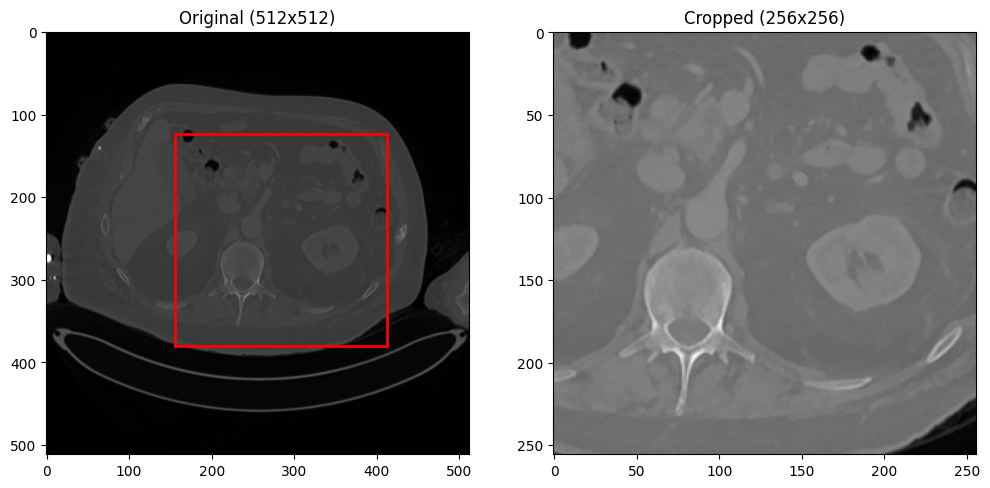

In [21]:
patient_id = 'rtum6'
sample_image_path = os.path.join(data_dir, patient_id, "SEQ", f"CTport-{patient_id}.nii")

visualize_crop(sample_image_path)

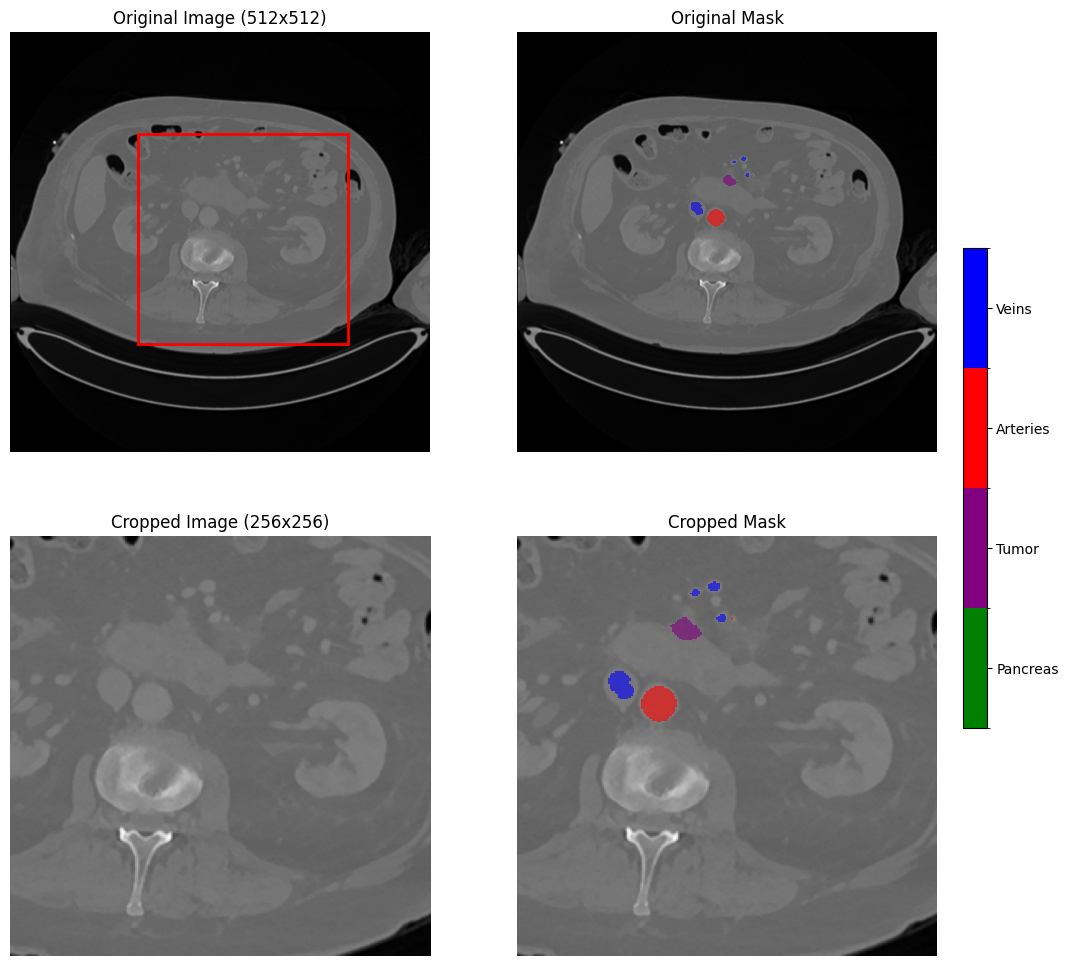

In [22]:
patient_id = 'rtum6'
sample_patient_dir = os.path.join(data_dir, patient_id)

# Visualize before and after cropping
visualize_crop_with_mask(sample_patient_dir, 10)

## __Count sacrificed pixels__

#### __Functions__

In [23]:
def load_combined_mask(patient_dir):
    """
    Loads and combines segmentation masks into a single array.

    Parameters:
    -----------
    patient_dir : str
        Path to the patient's directory.

    Returns:
    --------
    mask : np.ndarray
        Combined mask with class labels.
    """
    patient_id = os.path.basename(os.path.normpath(patient_dir))
    image_path = os.path.join(patient_dir, "SEQ", f"CTport-{patient_id}.nii")
    mask_paths = {
        1: os.path.join(patient_dir, "SEG", f"Pancreas-{patient_id}.nii"),
        2: os.path.join(patient_dir, "SEG", f"Tumor-{patient_id}.nii"),
        3: os.path.join(patient_dir, "SEG", f"Arterias-{patient_id}.nii"),
        4: os.path.join(patient_dir, "SEG", f"Venas-{patient_id}.nii"),
    }

    image_nii = nib.load(image_path)
    _, transform = reorient(image_nii)

    # Get the shape from the first mask
    shape = nib.load(next(iter(mask_paths.values()))).shape
    combined_mask = np.zeros(shape, dtype=np.uint8)

    # Load and combine masks
    for label, path in mask_paths.items():
        mask_nii = nib.load(path)
        if mask_nii.shape[2] != image_nii.shape[2]:
            mask_nii = resample_from_to(mask_nii, image_nii, order=0)
        mask_data = mask_nii.get_fdata()
        mask_data = (mask_data > 0).astype(np.uint8)  # Binarize
        mask_data = apply_orientation(mask_data, transform) # Apply orientation
        mask_data = np.rot90(mask_data, k=-1, axes=(0,1))
        combined_mask[mask_data > 0] = label  # Assign label

    return combined_mask

def compute_pixel_loss(patients, data_dir):
    """
    Computes the number of sacrificed pixels due to cropping.

    Parameters:
    -----------
    patients : list
        List of patient IDs.
    data_dir : str
        Root directory containing patient data.

    Returns:
    --------
    pixel_loss : dict
        Dictionary with original, post-crop, and sacrificed pixel counts per class.
    """
    # Initialize global counters
    total_pixels_before = {i: 0 for i in range(1, 5)}
    total_pixels_after = {i: 0 for i in range(1, 5)}

    # Iterate through each patient
    for patient in patients:
        patient_dir = os.path.join(data_dir, patient)
        
        # Load the full mask
        mask = load_combined_mask(patient_dir)

        # Count pixels per class before cropping
        unique, counts = np.unique(mask, return_counts=True)
        counts_before = dict(zip(unique, counts))

        # Apply cropping
        cropped_mask = mask[h_min:h_max, w_min:w_max, :]

        # Count pixels per class after cropping
        unique_crop, counts_crop = np.unique(cropped_mask, return_counts=True)
        counts_after = dict(zip(unique_crop, counts_crop))

        # Accumulate global counts
        for class_label in range(1, 5):
            total_pixels_before[class_label] += counts_before.get(class_label, 0)
            total_pixels_after[class_label] += counts_after.get(class_label, 0)

    # Compute sacrificed pixels
    pixel_loss = {
        class_label: {
            "original": total_pixels_before[class_label],
            "after_crop": total_pixels_after[class_label],
            "sacrificed": total_pixels_before[class_label] - total_pixels_after[class_label],
        }
        for class_label in range(1, 5)
    }

    return pixel_loss

def print_pixel_loss(pixel_loss):
    """
    Formats and prints the pixel loss results clearly.

    Parameters:
    -----------
    pixel_loss : dict
        Dictionary with original, post-crop, and sacrificed pixel counts per class.
    """
    class_names = {
        1: 'Pancreas',
        2: 'Tumor',
        3: 'Arteries',
        4: 'Veins'
    }
    print("\n📊 OVERALL SACRIFICED PIXELS:\n")
    print(f"{'Class':<10}{'Original':>15}{'After Cropping':>25}{'Sacrificed':>15}")
    print("-" * 65)

    for class_label, values in pixel_loss.items():
        original = values["original"]
        after_crop = values["after_crop"]
        sacrificed = values["sacrificed"]

        print(f"{class_names[class_label]:<10}{original:>15,}{after_crop:>25,}{sacrificed:>15,}")

#### __Compute__

In [24]:
pixel_loss = compute_pixel_loss(train_patients, data_dir)

#### __Results__

In [25]:
print_pixel_loss(pixel_loss)


📊 OVERALL SACRIFICED PIXELS:

Class            Original           After Cropping     Sacrificed
-----------------------------------------------------------------
Pancreas        5,296,843                5,296,588            255
Tumor             985,387                  985,387              0
Arteries        3,641,304                3,641,288             16
Veins           4,744,301                4,744,097            204


# __Conclusion__

After checking the number of sacrified pixels globally, we can determine that the data will be cropped to 256x256 by using these limits:
|  | Min | Max | 
|------|-----|-----|
| Height | 124 | 380 |
| Width | 156 | 412 |